# Uncertainty-Aware Road Obstacle Identification

In this notebook, we propose an implementation of Road Obstacle Identification architecture, with the addition of a certain threshold of confidence to uncertainty, thanks to a state-of-the-art approach to loss function computations, the so called "Boundary Aware Binary Cross Entropy". These are the main implemented topics:
- **Multilabel One-Hot Encoding**
- **DeepLabV3+ --> ResNet50**
- **Boundary Aware BCE**

## Import Necessary Libraries

In [23]:
import torch
import sklearn
import os
from PIL import Image
import torch
import torch.nn as nn
from tqdm import tqdm
import cv2
import numpy as np
import shutil
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

## Globals

In [24]:
# Macro class index mapping
MACRO_CLASSES = {
    "road": 0,
    "flat": 1,
    "human": 2,
    "vehicle": 3,
    "construction": 4,
    "background": 5,
    "object": 6,  # auxiliary objectness channel
}

# Map from original label ID to (macro class or None, is_object)   [None is only for the poles and traffic signs and lights]
CLASS_MAPPING = {
    7: ("road", False), # road
    8: ("flat", False), # sidewalk
    11: ("construction", False), # building
    12: ("construction", False), # wall
    13: ("construction", False), # fence
    17: (None, True),  # pole
    19: (None, True),  # traffic sign
    20: (None, True),  # traffic light
    21: ("background", False), # vegetation
    22: ("flat", False), # terrain
    23: ("background", False), # sky
    24: ("human", True), # person
    25: ("human", True), # rider
    26: ("vehicle", True), # car
    27: ("vehicle", True), # truck
    28: ("vehicle", True), # bus
    31: ("vehicle", True), # train
    32: ("vehicle", True), # motorcycle
    33: ("vehicle", True), # bicycle
}

## Utils

### Preprocessing

**Fixing the Dataset**

Here is the function to fix the structure of the dataset, downloaded from the official CityScapes website linked in the README file, from its original form to a preferred one, following the structure defined therein

In [25]:
is_fix = False  # if True, the dataset will be fixed using fix_dataset function
is_delete = False  # if True, the city folders will be deleted after copying using fix_dataset function

In [26]:
def fix_dataset(path_in, path_out):
    """
    Fixes the dataset by renaming the files and removing the city folders.
    """
    splits = ['train', 'val', 'test']
    
    if is_fix:
        for split in splits:
            count = 1
            img_dir = os.path.join(path_in, 'img', split)
            label_dir = os.path.join(path_in, 'label', split)

            # New destination directories
            img_out = os.path.join(path_out, 'img', split)
            label_out = os.path.join(path_out, 'label', split)
            os.makedirs(img_out, exist_ok=True)
            os.makedirs(label_out, exist_ok=True)

            # Iterate on sub-folders
            for city in os.listdir(img_dir):
                city_img_dir = os.path.join(img_dir, city)
                city_label_dir = os.path.join(label_dir, city)

                if not os.path.isdir(city_img_dir):
                    continue  # Skips non-directory files

                for filename in os.listdir(city_img_dir):
                    if not filename.endswith('leftImg8bit.png'):
                        continue
                    img_path = os.path.join(city_img_dir, filename)
                    base_prefix = filename.replace('_leftImg8bit.png', '')

                    # Renames and copies RGB
                    new_base = f"{split}{count}"
                    ext = '.png'
                    new_img_name = f"{new_base}{ext}"
                    shutil.copy(img_path, os.path.join(img_out, new_img_name))
                        
                    # Renames and copies all 'label' associated files
                    suffixes = ['_gtFine_labelIds.png', '_gtFine_color.png', '_gtFine_instanceIds.png', '_gtFine_polygons.json']
                    for suffix in suffixes:
                        if suffix == '_gtFine_labelIds.png':
                            original_name = base_prefix + suffix
                            source = os.path.join(city_label_dir, original_name)
                            if os.path.exists(source):
                                new_name = f"{new_base}_l.png"  # es. train1_color.png
                                shutil.copy(source, os.path.join(label_out, new_name))
                        else:
                            continue

                    count += 1
                    
                if is_delete:        
                    # Cleans city folders if empty
                    if os.path.isdir(city_img_dir) and not os.listdir(city_img_dir):
                        os.rmdir(city_img_dir)
                    if os.path.isdir(city_label_dir) and not os.listdir(city_label_dir):
                        os.rmdir(city_label_dir)

                    # Removes split folders if empty
                    for d in [img_dir, label_dir]:
                        if os.path.isdir(d) and not os.listdir(d):
                            os.rmdir(d)

fix_dataset('cityscapes_old', 'cityscapes_f')

**Converting Data**

With these functions, we convert labels and images from the dataset into PyTorch tensors, in order to feed them to the network and begin the training process

In [27]:
# Prepare a mapping from original labels to macro class index (0 to 6)
# For original labels mapped to None macro class (like poles, signs, lights), only 'object' class (6) will be set.

LABEL_TO_MACRO_IDX = {}

for original_id, (macro_class, is_object) in CLASS_MAPPING.items():
    if macro_class is not None:
        LABEL_TO_MACRO_IDX[original_id] = MACRO_CLASSES[macro_class]
    else:
        # For None macro class, we don't assign a macro_idx (only object channel will be set)
        LABEL_TO_MACRO_IDX[original_id] = None


def convert_label_to_multilabel_one_hot(label: torch.Tensor) -> torch.Tensor:
    """
    Converts label [H, W] with Cityscapes original IDs into a multi-label one-hot encoding tensor [7, H, W].
    The last channel (index 6) corresponds to the 'object' auxiliary channel.
    """
    height, width = label.shape
    multilabel = torch.zeros((7, height, width), dtype=torch.uint8)

    for original_id, (_, is_object) in CLASS_MAPPING.items():
        mask = (label == original_id)
        macro_idx = LABEL_TO_MACRO_IDX[original_id]

        if macro_idx is not None:
            multilabel[macro_idx][mask] = 1.0

        if is_object:
            multilabel[MACRO_CLASSES["object"]][mask] = 1.0

    return multilabel


def convert_image_to_tensor(image_path: str) -> torch.Tensor:
    """
    Converts an image from a file path to a tensor with shape [3, H, W] with normalization.
    """
    transform = T.Compose([
        T.ToTensor(),  # converts in [0, 1], shape [3, H, W]
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image)

**Boundaries Detection**

Here we compute the boundary mask on the ground truth segmentation labels, to tell the model “this is a boundary region, pay more attention here”.

To do that we use morphological gradient (difference between the dilation and the erosion of the image):
- **Dilation**: expand the region of each class, boundary pixels move away from the center of the region (each pixel replaced with maximum value in its neighborhood)
- **Erosion**: reduce the region of each class, boundary pixels move toward the center of the region (each pixel replaced with minimum value in its neighborhood)

In [28]:
def get_boundary_mask(label_mask, kernel_size=3):
    """
    Computes the boundary mask from a label mask using morphological operations.
    Args:
        label_mask (numpy.ndarray): Input label mask with shape [H, W].
        kernel_size (int): Size of the kernel for morphological operations.
    Returns:
        numpy.ndarray: Boundary mask with shape [H, W].
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(label_mask, kernel, iterations=2)
    eroded = cv2.erode(label_mask, kernel, iterations=2)
    boundary = (dilated != eroded).astype(np.uint8)
    return boundary

### Visualization

Some functions to show the aforementioned preprocessing, useful to visualize the data we are working with

In [29]:
class_names_7 = ["road", "flat", "human", "vehicle", "construction", "background", "object"]

def visualize_one_hot_vertical(one_hot, class_names=None, max_classes=7):
    """
    Visualizes the one-hot encoded masks vertically.
    """
    num_classes = min(one_hot.shape[0], max_classes)
    fig, axes = plt.subplots(num_classes, 1, figsize=(5, 3 * num_classes))

    for i in range(num_classes):
        ax = axes[i]
        ax.imshow(one_hot[i], cmap='gray')
        title = f"Class {i}" if class_names is None else class_names[i]
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [30]:
def visualize_erosion_mask(label_mask):
    """
    Visualizes the erosion mask of a label mask.
    """
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(label_mask, kernel, iterations=2)
    plt.figure()
    plt.imshow(erosion, cmap='gray')
    plt.title("Erosion Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_dilation_mask(label_mask):
    """
    Visualizes the dilation mask of a label mask.
    """
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv2.dilate(label_mask, kernel, iterations=2)
    plt.figure()
    plt.imshow(dilation, cmap='gray')
    plt.title("Dilation Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_boundary_mask(label_mask):
    """
    Visualizes the boundary mask.
    """
    boundary = get_boundary_mask(label_mask)
    plt.figure()
    plt.imshow(boundary, cmap='gray')
    plt.title("Boundary Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Data

In [31]:
class CityscapesDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_paths = sorted(Path(img_dir).glob("*.png"))
        self.label_paths = sorted(Path(label_dir).glob("*.png"))
        self.transform = transform  # eventuali transform aggiuntive

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = convert_image_to_tensor(self.img_paths[idx])
        label = Image.open(self.label_paths[idx])
        label_tensor = torch.as_tensor(np.array(label), dtype=torch.uint8)
        label_onehot = convert_label_to_multilabel_one_hot(label_tensor)

        return img, label_onehot

In [33]:
train_set = CityscapesDataset('cityscapes_f/img/train', 'cityscapes_f/label/train')
val_set = CityscapesDataset('cityscapes_f/img/val', 'cityscapes_f/label/val')
test_set = CityscapesDataset('cityscapes_f/img/test', 'cityscapes_f/label/test')

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

for imgs, labels in train_loader:
    print("Batch of images shape:", imgs.shape)  # Should be [B, 3, H, W]
    print("Batch of labels shape:", labels.shape)  # Should be [B, 7, H, W]
    break  # Just to check the first batch

Batch of images shape: torch.Size([4, 3, 1024, 2048])
Batch of labels shape: torch.Size([4, 7, 1024, 2048])


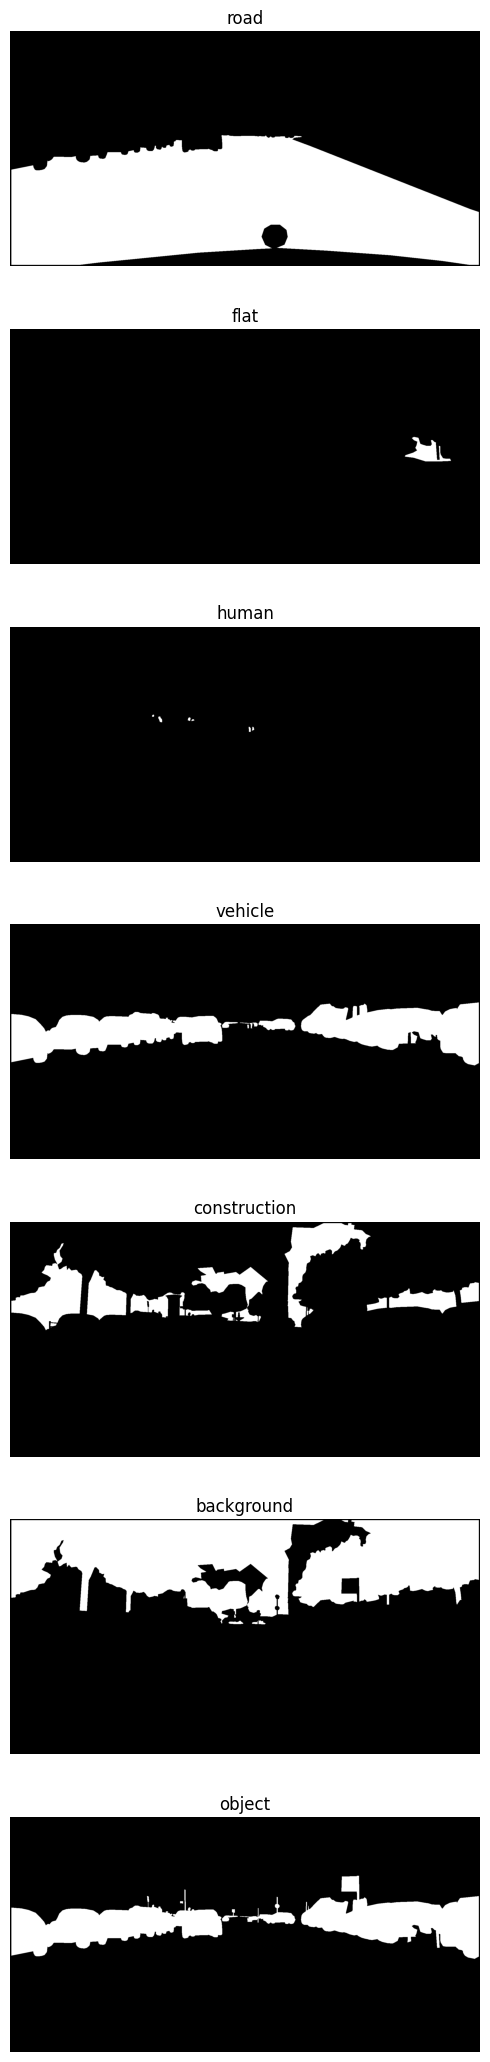

In [35]:
visualize_one_hot_vertical(labels[1], class_names=class_names_7)

## Network

In [ ]:
# resnet can be taken from this library, add the remaining backbones as needed
network = smp.Unet('resnet50', classes=7, activation='sigmoid')
# TODO: rest of the code for the network

### Loss Function

**Boundary Aware BCE**

Following the format of how to create a custom loss function according to:
https://medium.com/we-talk-data/crafting-custom-loss-functions-in-pytorch-an-advanced-guide-830ff717163e

- lambda_weight: weight lambda of the formula
- pred: tensor of the outputs of the sigmoid head, the dimension is (B, C, H, W) with B batch size, C classes ...
- target: ground truth one hot encoded with dimension (B, C, H, W)
- boundary_mask: mask computed using get_boundary_mask() where 1 indicates boundary pixel, dimension (B, 1, H, W)

In [ ]:
class BoundaryAwareBCELoss(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        #to avoid log(0)
        eps = 1e-7

        #standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
        normal_term = bce.mean()

        boundary_mask = boundary_mask.float()  #to keep??
        #expansion to (B, C, H, W) to do the multiplication
        boundary_mask = boundary_mask.expand(-1, pred.shape[1], -1, -1)

        #boundary aware BCE loss
        boundary_bce = bce * boundary_mask
        boundary_pixels = boundary_mask.sum(dim=(1, 2, 3)).clamp(min=1.0) #boundary pixels of each image
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

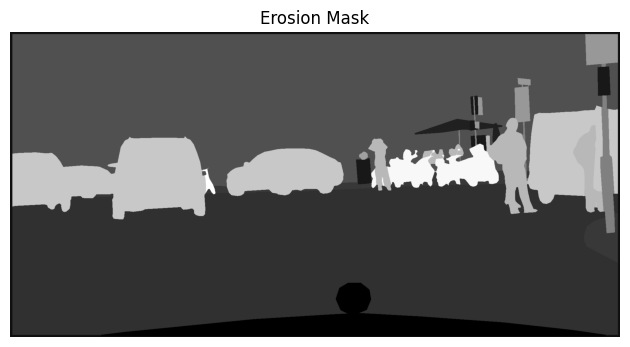

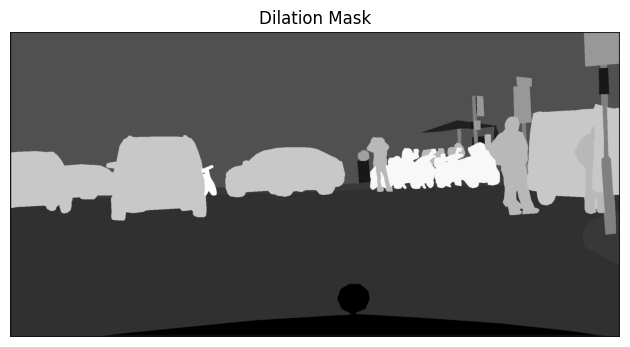

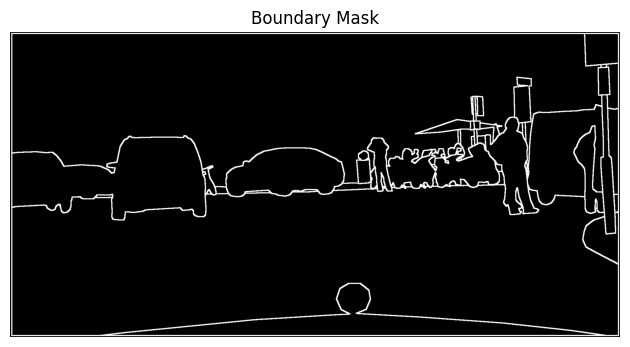

In [13]:
visualize_erosion_mask(np.array(Image.open('cityscapes_f/label/train/train1_l.png')))
visualize_dilation_mask(np.array(Image.open('cityscapes_f/label/train/train1_l.png')))
visualize_boundary_mask(np.array(Image.open('cityscapes_f/label/train/train1_l.png')))

## Train

In [ ]:
# TODO: train the network with the custom loss function, eventually plot confusion matrix

## Test

In [ ]:
# TODO: test the network